In [ ]:
pip install yfinance

In [2]:
#yahoo finance as data source
import yfinance as yf

In [3]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [4]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-06,115.750031,117.400032,114.750031,116.487526,94.566078,8345101
2017-11-07,117.000031,119.412529,114.987526,115.875031,94.068855,15277560
2017-11-08,115.875031,116.950027,113.837524,114.312531,92.800392,10552197
2017-11-09,115.125031,115.700027,112.000031,112.775024,91.552216,12770876
2017-11-10,113.687531,115.925026,112.550026,114.275024,92.769951,16137311


In [7]:
len(data)

1236

In [9]:
opn = data[['Open']]

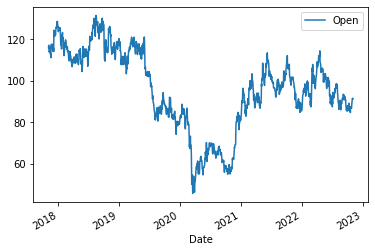

In [10]:
opn.plot()

In [15]:
import numpy as np

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [18]:
len(ds_scaled), len(ds)

(1236, 1236)

In [19]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [21]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [22]:
len(ds_train),len(ds_test)

(865, 371)

In [23]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [24]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [25]:
X_train.shape,y_train.shape

((764, 100), (764,))

In [26]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [27]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [29]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 6s 194ms/step - loss: 0.1439 - val_loss: 0.0052
Epoch 2/100
12/12 [==============================] - 1s 111ms/step - loss: 0.0191 - val_loss: 0.0101
Epoch 3/100
12/12 [==============================] - 1s 112ms/step - loss: 0.0116 - val_loss: 0.0048
Epoch 4/100
12/12 [==============================] - 1s 104ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 5/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 6/100
12/12 [==============================] - 1s 117ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 7/100
12/12 [==============================] - 1s 111ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 8/100
12/12 [==============================] - 2s 131ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 9/100
12/12 [==============================] - 1s 123ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 10/100
12/12 [==============================] - 1s 109ms/step - loss: 0.0041 - val_lo

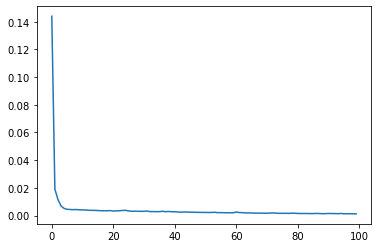

In [31]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [32]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 20ms/step


In [33]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

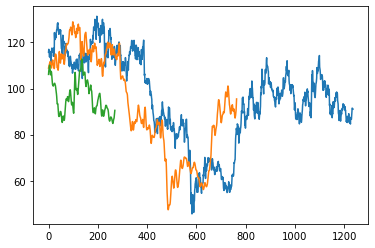

In [34]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [35]:
type(train_predict)

numpy.ndarray

In [36]:
test = np.vstack((train_predict,test_predict))

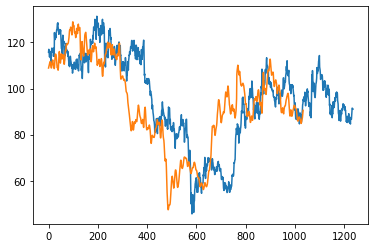

In [37]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [38]:
len(ds_test)

371

In [39]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [40]:
fut_inp = fut_inp.reshape(1,-1)

In [41]:
tmp_inp = list(fut_inp)

In [42]:
fut_inp.shape

(1, 101)

In [43]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [44]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.5321270823478699], [0.5311204791069031], [0.5291839838027954], [0.5270729660987854], [0.525151252746582], [0.5236166715621948], [0.5225806832313538], [0.5220914483070374], [0.522142231464386], [0.5226836800575256], [0.5236353278160095], [0.5249001383781433], [0.5263754725456238], [0.5279631018638611], [0.5295759439468384], [0.5311432480812073], [0.5326122045516968], [0.5339488983154297], [0.5351372957229614], [0.5361767411231995], [0.5370790362358093], [0.5378643870353699], [0.5385586619377136], [0.5391897559165955], [0.5397844910621643], [0.540367841720581], [0.5409594774246216], [0.5415747761726379], [0.5422237515449524], [0.5429121851921082]]


In [45]:
len(ds_scaled)

1236

In [46]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [48]:
ds_scaled.shape

(1236, 1)

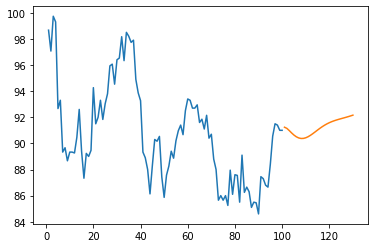

In [49]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1136:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [50]:
ds_new = ds_scaled.tolist()

In [51]:
len(ds_new)

1236

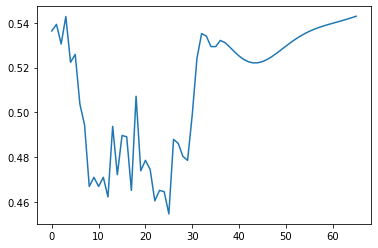

In [52]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [53]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

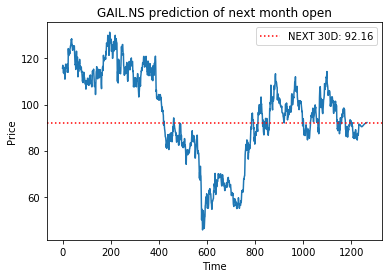

In [54]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

